# **IMPORT PACKAGES**
**Required packages for Twitter Bot project**

In [5]:
import pandas as pd
import openpyxl
import snscrape.modules.twitter as sntwitter
import snscrape.modules.reddit as snreddit
import re
import psycopg2
import pandas.io.sql as sqlio
from sqlalchemy import create_engine
import warnings

pd.set_option('display.max_colwidth', 0) # Set dataframe output width max
warnings.filterwarnings("ignore") # ignore warnings for the case of nltk

# **LOAD 500K Tweets about ChatGPT**
**Load 500K Tweets from January 2023 - March 2023 from kaggle.com dataset**

In [6]:
df_kaggle = pd.read_csv('Tweets_chatgpt_Jan Mar 2023.csv')
df_kaggle.head(1)

,date,id,content,username,like_count,retweet_count
0,2023-03-29 22:58:21+00:00,1641213230730051584,"Free AI marketing and automation tools, strategies, and collaboration launching new week https://t.co/Qwti8LfBpb #ChatGPT",RealProfitPros,0.0,0.0


In [7]:
# Check for ads
ads = df_kaggle['content'].fillna('').str.contains('promotedmetadata', case=False)
df_ads = df_kaggle.loc[ads, :]
df_ads.head(2)

,date,id,content,username,like_count,retweet_count


In [8]:
# Dataframe Analysis
print("Length: ",len(df_kaggle))
print("Shape: ",df_kaggle.shape)

# Calculate the length of each tweet AS a STRING and store it in a list
tweet_lengths = [len(str(tweet)) for tweet in df_kaggle['content']]

# Max, MIn, Average tweet length
max_tweet_length = max(tweet_lengths)
min_tweet_length = min(tweet_lengths)
avg_tweet_length = sum(tweet_lengths) / len(tweet_lengths)

print("Max Tweet length is:", max_tweet_length)
print("Min Tweet length is:", min_tweet_length)
print("Average Tweet length is:", avg_tweet_length)

# Check NULL values
print("NULL Values Count: \n", df_kaggle.isnull().sum())

Length:  500036
Shape:  (500036, 6)
Max Tweet length is: 985
Min Tweet length is: 1
Average Tweet length is: 167.30369813373437
NULL Values Count: 
 date             0 
id               6 
content          6 
username         34
like_count       62
retweet_count    62
dtype: int64


In [9]:
# Clean Tweet Function

def clean_tweets(tweet):
    tweet = str(tweet) # Convert input to string
    tweet = re.sub(r'@\w+', '', tweet) # Remove @ tags
    # tweet = re.sub(r'#\w+', '', tweet) # Remove hashtags
    tweet = re.sub(r'https?:\/\/\S+','',tweet) # Remove hyperlinks
    tweet = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b','',tweet) # Remove email addresses
    tweet = re.sub(r'[\r\n]+', ' ', tweet) # Remove new line characters
    tweet = re.sub(r'\s+', ' ', tweet) # Remove multiple space characters
    tweet = tweet.lower() # Convert to lowercase

    return tweet

df_kaggle['content_clean'] = df_kaggle['content'].apply(clean_tweets)

# Convert the 'date' column to a datetime object and extract the date component
df_kaggle['date'] = pd.to_datetime(df_kaggle['date'], errors='coerce').dt.date

# Convert the 'date' column back to a datetime object
df_kaggle['date'] = pd.to_datetime(df_kaggle['date'])

df_kaggle.head(10)

,date,id,content,username,like_count,retweet_count,content_clean
0,2023-03-29,1641213230730051584,"Free AI marketing and automation tools, strategies, and collaboration launching new week https://t.co/Qwti8LfBpb #ChatGPT",RealProfitPros,0.0,0.0,"free ai marketing and automation tools, strategies, and collaboration launching new week #chatgpt"
1,2023-03-29,1641213218520481805,@MecoleHardman4 Chat GPT says it’s 15. 😂,AmyLouWho321,0.0,0.0,chat gpt says it’s 15. 😂
2,2023-03-29,1641213115684536323,"https://t.co/FjJSprt0te - Chat with any PDF!\nCheck out how this new AI quickly answers questions from your PDFs.\nPerfect for students, researchers, and other curious minds. \n#research #chatpdf #ChatGPT",yjleon1976,0.0,0.0,"- chat with any pdf! check out how this new ai quickly answers questions from your pdfs. perfect for students, researchers, and other curious minds. #research #chatpdf #chatgpt"
3,2023-03-29,1641213110915571715,"AI muses: ""In the court of life, we must all face the judge of destiny and the jury of our actions. ⚖️🔮 #OutOfContextAI #AILifeLessons #ChatGPT",ChatGPT_Thinks,0.0,0.0,"ai muses: ""in the court of life, we must all face the judge of destiny and the jury of our actions. ⚖️🔮 #outofcontextai #ailifelessons #chatgpt"
4,2023-03-29,1641213003260633088,"Most people haven't heard of Chat GPT yet.\nFirst, elite factions will decide which way to go on AI safety. Next they will push their agenda(s) on the public with misleading and oversimplified media presentations. Finally, the brainless Red and Blue camps will screech their lines",nikocosmonaut,0.0,0.0,"most people haven't heard of chat gpt yet. first, elite factions will decide which way to go on ai safety. next they will push their agenda(s) on the public with misleading and oversimplified media presentations. finally, the brainless red and blue camps will screech their lines"
5,2023-03-29,1641212975012016128,@nytimes No! Chat Gpt has been putting together amazing recipes 😫😫😫,cordydbarb,0.0,0.0,no! chat gpt has been putting together amazing recipes 😫😫😫
6,2023-03-29,1641212917868646400,@ylzkrtt Yes also by chat gpt you can make generative art more easy but needs code KNOWLEDGE. I did post resently some article about this matter. Take a look.,gomezfidelphani,1.0,0.0,yes also by chat gpt you can make generative art more easy but needs code knowledge. i did post resently some article about this matter. take a look.
7,2023-03-29,1641212902375063552,"@robinhanson @razibkhan Most people haven't heard of Chat GPT yet.\nFirst, elite factions will decide which way to go on AI safety. Next they will push their agenda(s) on the public with misleading and oversimplified media presentations. Finally, the brainless Red and Blue camps will screech their lines",nikocosmonaut,0.0,0.0,"most people haven't heard of chat gpt yet. first, elite factions will decide which way to go on ai safety. next they will push their agenda(s) on the public with misleading and oversimplified media presentations. finally, the brainless red and blue camps will screech their lines"
8,2023-03-29,1641212856984109072,Yours Robotically - by Shaun Usher - Letters of Note | I think #ChatGPT has been reading too many steamy romance novels 😂 https://t.co/r8WTOs1hYZ,lawyermarketer,0.0,0.0,yours robotically - by shaun usher - letters of note | i think #chatgpt has been reading too many steamy romance novels 😂
9,2023-03-29,1641212845441585152,This is a metaphor for the limited perception of reality that many people experience and is used in #TheMatrix to add depth and complexity to the film's themes #BCM325 #ChatGPT \nhttps://t.co/2S2Dy7Fqd0,ashleighgrente2,2.0,0.0,this is a metaphor for the limited perception of reality that many people experience and is used in #thematrix to add depth and complexity to the film's themes #bcm325 #chatgpt


In [10]:
# Check NULL values
nulls = df_kaggle.isnull()
df_nulls = df_kaggle[nulls.any(axis=1)]
df_nulls.head(10)

,date,id,content,username,like_count,retweet_count,content_clean
34984,2023-03-25,1639502710285410304,How the Federal Government Wants to “Root Out Discrimination” From Artificial Intelligence Systems,NaN,NaN,NaN,how the federal government wants to “root out discrimination” from artificial intelligence systems
34985,NaT,NaN,NaN,NaN,NaN,NaN,nan
34986,NaT,rightwirereport,0,0,NaN,NaN,0
56153,2023-03-22,1638563713023107077,Google allow early access to its ChatGPT rival Bard. Details Here!,NaN,NaN,NaN,google allow early access to its chatgpt rival bard. details here!
56154,NaT,NaN,NaN,NaN,NaN,NaN,nan
56155,NaT,Gossipviral76,0,0,NaN,NaN,0
114179,2023-03-15,1635940919802499072,🌟⭐️✨ https://t.co/xQPxEJpNcH is now available for sale,NaN,NaN,NaN,🌟⭐️✨ is now available for sale
114180,NaT,billnco,2,2,NaN,NaN,2
172934,2023-03-04,1631849072608043009,🌟⭐️✨ https://t.co/H7mplqY8Ys is now available for sale,NaN,NaN,NaN,🌟⭐️✨ is now available for sale
172935,NaT,billnco,0,1,NaN,NaN,0


In [11]:
# Remove NULL values
df_kaggle = df_kaggle.dropna()
print("Shape: ",df_kaggle.shape)

Shape:  (499974, 7)


In [12]:
# Back up before removing
df_backup = df_kaggle.copy(deep=True)

In [13]:
# Sort by like_count
df_kaggle_sort = df_kaggle.sort_values(by='like_count', ascending=False)

# Keep the duplicated tweet with highest likes
df_kaggle_nodupes = df_kaggle_sort.drop_duplicates(subset='content_clean', keep='first')

# Sort final dataframe by likes
df_cleaned = df_kaggle_nodupes.sort_values(by='like_count', ascending=False)

In [14]:
df_cleaned.shape

(465982, 7)

# **PSYCOPG2**
**Connection to PostgreSQL and import Pandas Dataframe to Database**

In [15]:
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

In [20]:
# Set attributes for Postgres connection
hostname = 'localhost'
database = 'DB1'
username = 'postgres'
pwd = 'XXXXX'
port_id = 5432

conn = None
pgcur = None

# Connect
try:
    conn = psycopg2.connect(
            host = hostname,
            dbname = database,
            user = username,
            password = pwd,
            port = port_id
    )

    conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)

    pgcur = conn.cursor()

    # Create Table execute
    pgcur.execute('''
    DROP TABLE IF EXISTS Tweets_ChatGPT_clean CASCADE;
    CREATE TABLE Tweets_ChatGPT_clean
        ( date date
        , id varchar(50)
        , content varchar(1000)
        , username varchar(50)
        , like_count int
        , retweet_count int
        , content_clean varchar(1000))
    ''')

    # Loop through rows in the df_kaggle_clean and execute the INSERT statement
    sql = "INSERT INTO Tweets_ChatGPT_clean (date, id, content, username, like_count, retweet_count, content_clean) VALUES (%s, %s, %s, %s, %s, %s, %s)"

    for index, row in df_cleaned.iterrows():
        values = (row['date'], row['id'], row['content'], row['username'], row['like_count'], row['retweet_count'], row['content_clean'])
        pgcur.execute(sql, values)

except Exception as error:
    print(error) # this will print sql error part only
finally:
    if pgcur is not None:
        pgcur.close()
    if conn is not None:
        conn.close()



In [23]:
'''Using pandas.io.sql as sqlio'''

# Open Postgres connection, read SQL views and store in dataframes

conn = psycopg2.connect(
            host = hostname,
            dbname = database,
            user = username,
            password = pwd,
            port = port_id
    )
    
df_daily_count_view = sqlio.read_sql_query('SELECT * FROM tweets_chatgpt_daily_count;', conn)

df_top10K_likes_view = sqlio.read_sql_query('SELECT * FROM tweets_chatgpt_top10K_likes;', conn)

conn.close()

# Check dfs
print('df_daily_count_view: \n', '\n',df_daily_count_view.head(5))
print('\n')
print('df_top10K_likes_view: \n')
df_top10K_likes_view.head(5)


df_daily_count_view: 
 
          date  count
0  2023-01-04  2792 
1  2023-01-05  4192 
2  2023-01-06  4075 
3  2023-01-07  3544 
4  2023-01-08  3381 


df_top10K_likes_view: 



,date,id,username,like_count,retweet_count,content_clean
0,2023-02-03,1621647164123365377,MoistCr1TiKaL,64094,2624,writing erotic prompts for chat gpt hoping to be the first person to make ai cum. it’s like the turing test
1,2023-01-13,1613755402608381952,johnvianny,63835,16080,best ai tools you need to know #chatgpt #chatgpt3 #artificialintelligence #ai
2,2023-03-06,1632538650897534980,rgay,44940,1349,"i am pretty sure i am reading my first chat gpt student essay and like, teachers, don't panic. you'll know it when you see it."
3,2023-01-07,1611581338351730688,aaronsiim,42125,11501,ultra-modern generative ai🗨️: • ai2 • ai21 • mdm • gpt-j • gpt-3 • x-clip • bloom • cohere • gopher • dall•e 2 • craiyon • tabnine • jukebox • chatgpt *** • anthropic • codegeex • nvidia get3d • dreamfusion • stable diffusion • meta make-a-video
4,2023-01-12,1613446745328963584,kevinschawinski,38278,4160,first #chatgpt answer which made me pause.


# **VISUALISATION**
**Data visualisation of cleaned dataframe**

In [24]:
import seaborn
import matplotlib.pyplot as pyplot
import matplotlib.dates as mdates
import yfinance # Yahoo Finance

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from PIL import Image
from random import choice


**BARCHARTS**

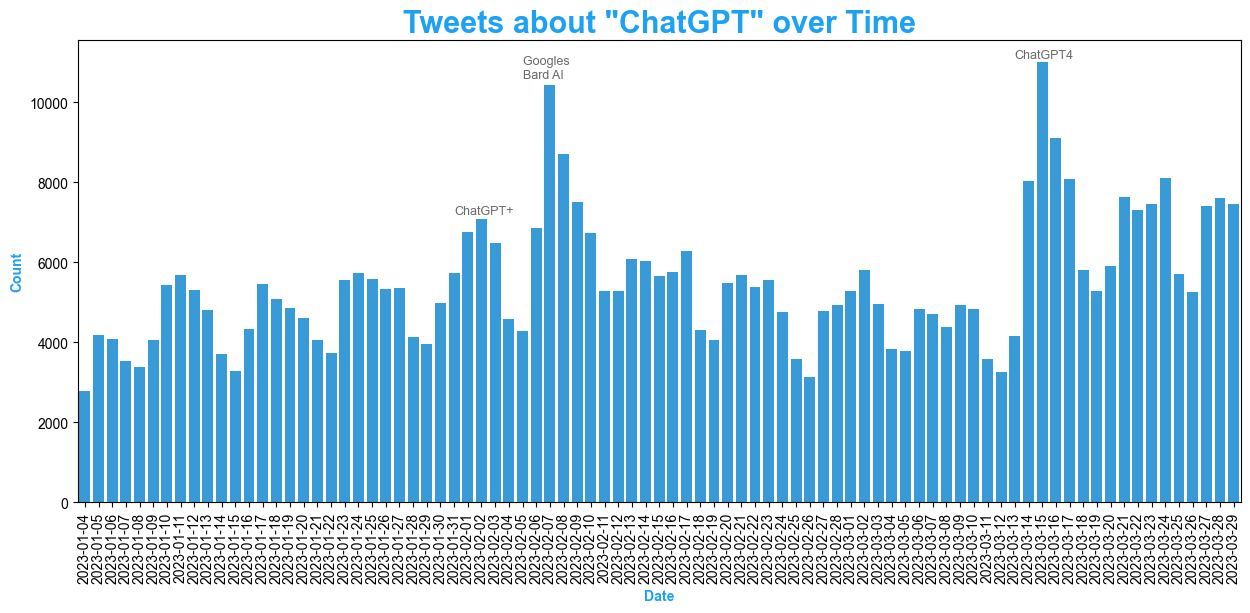

In [25]:
# Create Barchart and assign formatting
pyplot.figure(figsize=(15, 6))
seaborn.barplot(data= df_daily_count_view, x='date', y='count', color='#1DA1F2')

seaborn.set(rc={'xtick.color':'#1DA1F2', 'ytick.color':'#1DA1F2'})
pyplot.title('Tweets about "ChatGPT" over Time', fontsize=22, weight='bold', color='#1DA1F2')
pyplot.xticks(rotation=90)
pyplot.xlabel('Date', color='#1DA1F2', weight='bold')
pyplot.ylabel('Count', color='#1DA1F2', weight='bold')

# Add text labels
pyplot.text(32 , 10600, 'Googles \nBard AI', fontsize=9, color='dimgray')
pyplot.text(27 , 7200, 'ChatGPT+', fontsize=9, color='dimgray')
pyplot.text(68 , 11100, 'ChatGPT4', fontsize=9, color='dimgray')

# Store visualization to file
pyplot.savefig("Barchart_Tweet_Count.png", format="png")

# Show plot
pyplot.show()


In [26]:
# Retrieve MSFT and GOOGL stock data
start_date = '2023-01-04'
end_date = '2023-03-29'
ticker_symbols = ['MSFT', 'GOOGL'] 
# Create dataframe to store the Adjusted Close Price
stocks_df = yfinance.download(ticker_symbols, start=start_date, end=end_date)['Adj Close']
stocks_df.tail(1)


[*********************100%***********************]  2 of 2 completed


,GOOGL,MSFT
Date,,
2023-03-28,101.029999,274.629669


In [27]:
# Adjust dataframe date formatting back to YYYY-MM-DD
df_daily_count_view_YYYYMMDD = df_cleaned.groupby(pd.Grouper(key='date', freq='D')).size().reset_index(name='count').sort_values(by='date', ascending=True)

print(df_daily_count_view_YYYYMMDD.head(1))

        date  count
0 2023-01-04  2792 


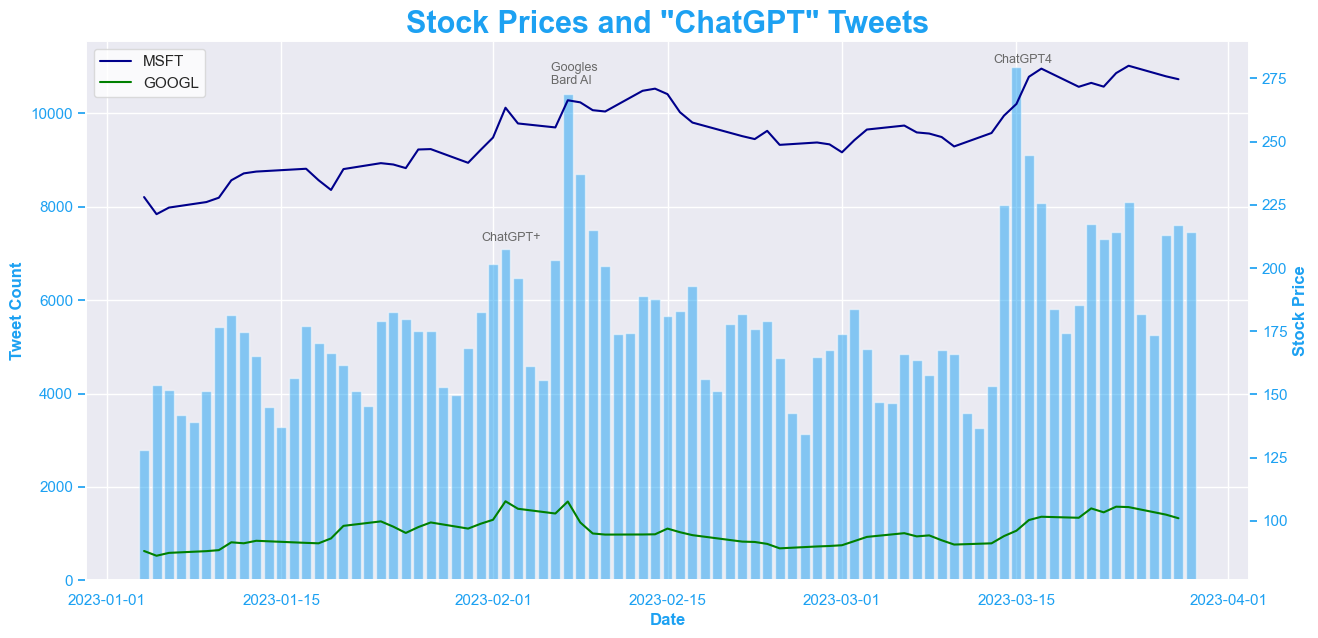

In [43]:

fig, ax1 = pyplot.subplots(figsize=(15, 7))

# Plot tweets
ax1.bar(df_daily_count_view_YYYYMMDD['date'], df_daily_count_view_YYYYMMDD['count'], color='#1DA1F2', alpha=0.5)
ax1.set_xlabel('Date', color='#1DA1F2', weight='bold')
ax1.set_ylabel('Tweet Count', color='#1DA1F2', weight='bold')
ax1.tick_params(axis='x')

# Plot stock prices
ax2 = ax1.twinx()
for symbol in ticker_symbols:
    if symbol == 'MSFT':
        ax2.plot(stocks_df.index, stocks_df[symbol], label=symbol, color='darkblue')
    else:
        ax2.plot(stocks_df.index, stocks_df[symbol], label=symbol, color='green')
ax2.set_ylabel('Stock Price', color='#1DA1F2', weight='bold')
ax2.legend(loc='upper left', facecolor='white', edgecolor='lightgrey')

# Add text labels
ax1.text(0.40, 0.92, 'Googles \nBard AI', transform=ax1.transAxes, fontsize=9, color='dimgray')
ax1.text(0.34, 0.63, 'ChatGPT+', transform=ax1.transAxes, fontsize=9, color='dimgray')
ax1.text(0.78, 0.96, 'ChatGPT4', transform=ax1.transAxes, fontsize=9, color='dimgray')


ax2.grid(False) # remove gridlines from ax2

pyplot.title('Stock Prices and "ChatGPT" Tweets', fontsize=22 ,color='#1DA1F2', weight='bold')

pyplot.savefig("Barchart_Tweet_Stock_Prices.png", format="png")


pyplot.show()


**LEMMATIZATION**

In [27]:
# import ssl

# # Disable SSL verification temporarily to enable nltk.download()

# ssl._create_default_https_context = ssl._create_unverified_context

In [29]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


False

In [30]:
# Initialize the lemmatizer
wordnet_lem = WordNetLemmatizer()

# Lemmatize tweet content 
df_cleaned['content_lemmatized'] = df_cleaned['content_clean'].apply(wordnet_lem.lemmatize)

# Join Lemmatize words into a list
words_lemmatized = ' '.join([word for word in df_cleaned['content_lemmatized']])

df_cleaned.head(2)


,date,id,content,username,like_count,retweet_count,content_clean,content_lemmatized
342707,2023-02-03,1621647164123365377,Writing erotic prompts for Chat GPT hoping to be the first person to make AI cum. It’s like the Turing Test,MoistCr1TiKaL,64094.0,2624.0,writing erotic prompts for chat gpt hoping to be the first person to make ai cum. it’s like the turing test,writing erotic prompts for chat gpt hoping to be the first person to make ai cum. it’s like the turing test
458850,2023-01-13,1613755402608381952,Best AI Tools You Need To Know\n#chatgpt #chatgpt3 #ArtificialIntelligence #ai https://t.co/0jfr8cOMoo,johnvianny,63835.0,16080.0,best ai tools you need to know #chatgpt #chatgpt3 #artificialintelligence #ai,best ai tools you need to know #chatgpt #chatgpt3 #artificialintelligence #ai


In [ ]:
# Filtered Dataframe check
filtered_df = df_cleaned[df_cleaned['content_lemmatized'].str.contains('chatgpt')]
re.sub(r'#S', '')
filtered_df.tail()

In [34]:
# Define a custom color function for Wordcloud
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = ['#1DA1F2', '#0D6EBD', '#095BAA', '#07497C', '#063D68', '#04314E', '#022436']
    return choice(colors)

#'#1DA1F2', '#00CC96', '#FF5733', '#FFC300', '#E91E63', '#9C27B0', '#673AB7'

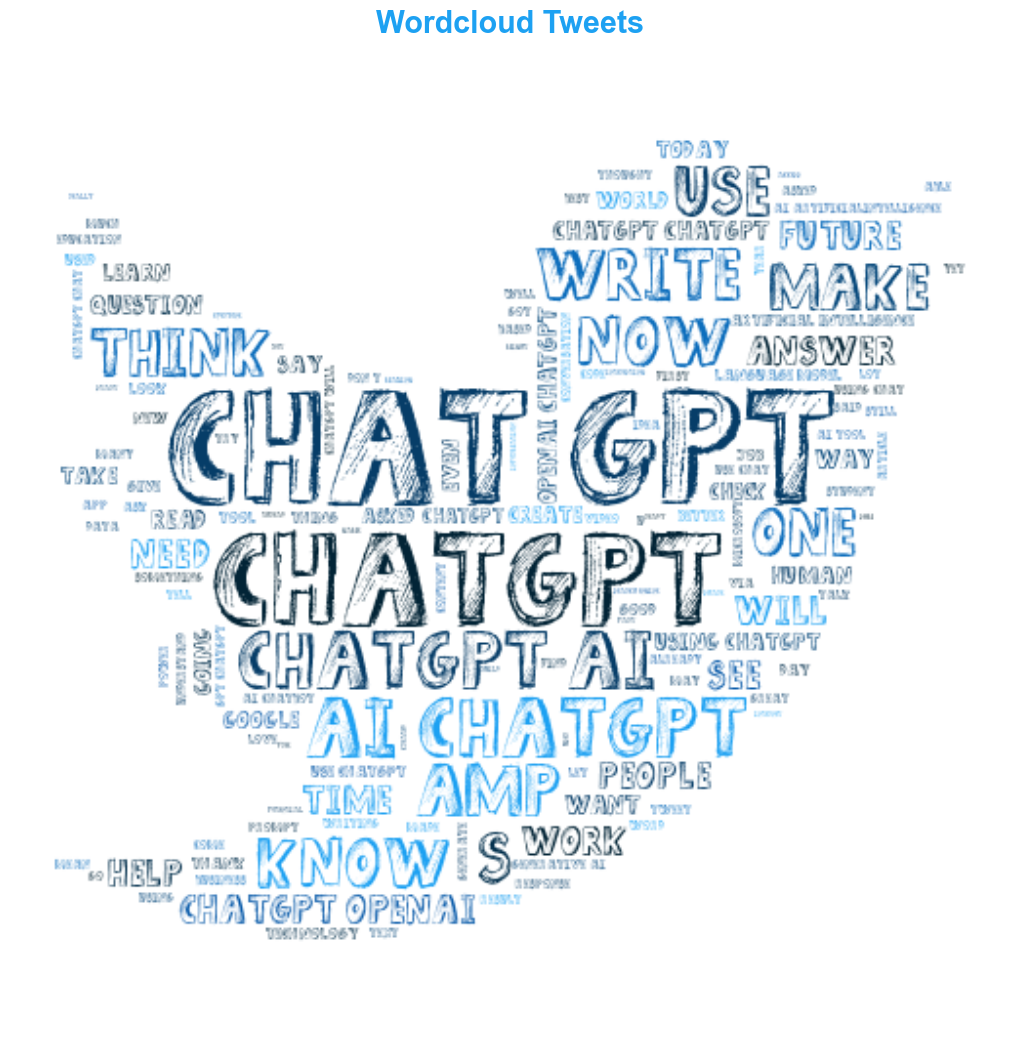

In [35]:
# Generate a word cloud image
mask = np.array(Image.open("Logo-Twitter.png"))
stopwords = set(STOPWORDS)
stopwords_update = stopwords.update({'#chatgpt'})

wordcloud_twitter = WordCloud(height=2000, width=2000,
                              background_color="white", mode="RGBA", font_path='SketchBook.ttf',
                              stopwords=stopwords_update, mask=mask, color_func=custom_color_func).generate(words_lemmatized)

# Create coloring from custom color function
pyplot.figure(figsize=[10, 10])
pyplot.axis('off')
pyplot.tight_layout(pad=0)
pyplot.imshow(wordcloud_twitter.recolor(color_func=custom_color_func), interpolation="bilinear")
pyplot.title('Wordcloud Tweets', fontsize=22 ,color='#1DA1F2', weight='bold')

# Store visualization to file
pyplot.savefig("Wordcloud_tweets.png", format="png")

pyplot.show()

In [36]:
# Custom multicolor function
def custom_color_func_2(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = ['#1DA1F2']
    return choice(colors)

In [37]:
# Extract mentions and concatenate all mentions in one string
all_tags = ' '.join([tag[1:] for tags in df_cleaned['content'].str.findall(r'@\w+') for tag in tags])

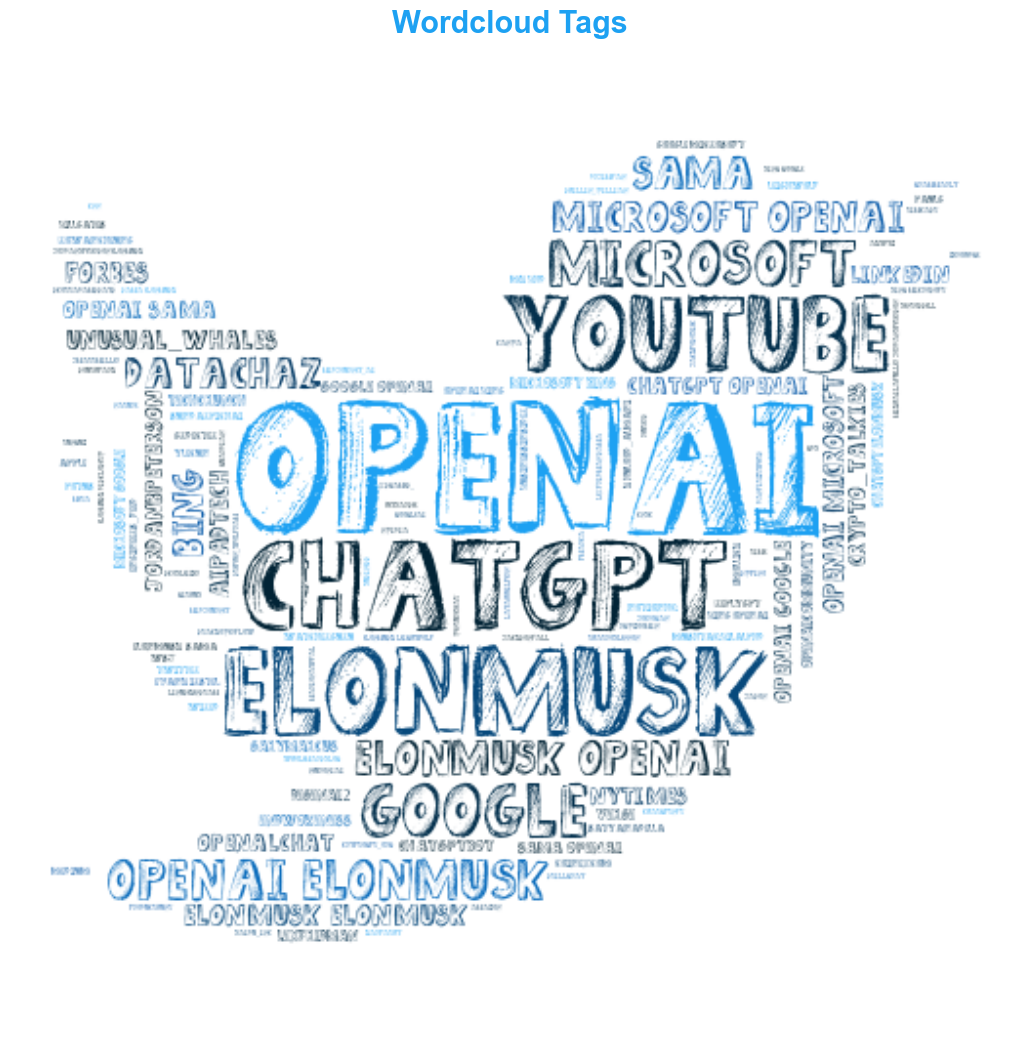

In [38]:
# Generate Wordcloud
wordcloud_twitter = WordCloud(height=2000, width=2000,
                              background_color="white", mode="RGBA",
                              stopwords=stopwords, mask=mask, color_func=custom_color_func,
                              font_path='SketchBook.ttf').generate(all_tags)

# Create coloring from custom color function we defined earlier
pyplot.figure(figsize=[10,10])
pyplot.axis('off')
pyplot.tight_layout(pad=0)
pyplot.imshow(wordcloud_twitter.recolor(color_func=custom_color_func), interpolation="bilinear")
pyplot.title('Wordcloud Tags', fontsize=22 ,color='#1DA1F2', weight='bold')

# Store visualization to file
pyplot.savefig("Wordcloud_tags.png", format="png")

pyplot.show()


# **SENTIMENT ANALYSIS**
**Check postivitiy vs negativity of 500K Tweets**

In [39]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import plotly.express as px

nltk.download('vader_lexicon')

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


False

In [46]:
# Set Vader Sentiment object
sia = SentimentIntensityAnalyzer()

# Get Sentiment for Top 10,000 most liked Tweets
df_top10K_likes_view['vader_polarity'] = df_top10K_likes_view['content_clean'].map(lambda text: sia.polarity_scores(text)['compound']) 

df_top10K_likes_view['textblob_polarity'] = df_top10K_likes_view['content_clean'].map(lambda text: TextBlob(text).sentiment.polarity)

df_polarity = df_top10K_likes_view[['vader_polarity', 'textblob_polarity']]

df_polarity.head(5)

,vader_polarity,textblob_polarity
0,0.6486,0.475000
1,0.6369,1.000000
2,0.8658,0.333333
3,0.2960,0.000000
4,0.0000,0.250000


In [47]:
df_polarity_10K = df_top10K_likes_view
df_polarity_10K.head(3)

,date,id,username,like_count,retweet_count,content_clean,vader_polarity,textblob_polarity
0,2023-02-03,1621647164123365377,MoistCr1TiKaL,64094,2624,writing erotic prompts for chat gpt hoping to be the first person to make ai cum. it’s like the turing test,0.6486,0.475000
1,2023-01-13,1613755402608381952,johnvianny,63835,16080,best ai tools you need to know #chatgpt #chatgpt3 #artificialintelligence #ai,0.6369,1.000000
2,2023-03-06,1632538650897534980,rgay,44940,1349,"i am pretty sure i am reading my first chat gpt student essay and like, teachers, don't panic. you'll know it when you see it.",0.8658,0.333333


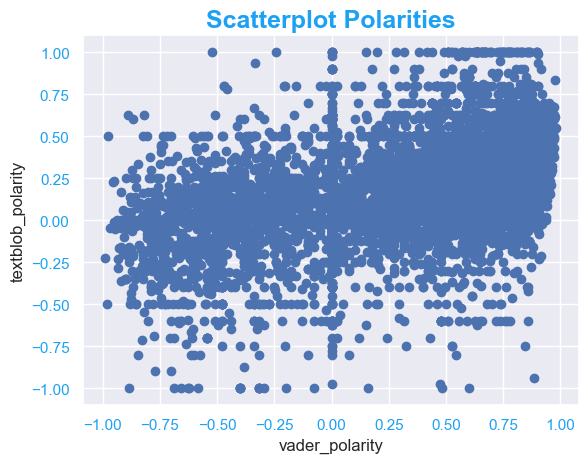

In [48]:
# Create a scatter plot of the data
pyplot.scatter(df_polarity_10K['vader_polarity'], df_polarity_10K['textblob_polarity'])

# Format chart

pyplot.xlabel('vader_polarity')
pyplot.ylabel('textblob_polarity')
pyplot.title('Scatterplot Polarities', fontsize=18 ,color='#1DA1F2', weight='bold')

# Store visualization to file
pyplot.savefig("Scatterplot_polarity.png", format="png")

# Show the plot
pyplot.show()

In [49]:
print(df_polarity_10K.columns)


Index(['date', 'id', 'username', 'like_count', 'retweet_count',
       'content_clean', 'vader_polarity', 'textblob_polarity'],
      dtype='object')


In [50]:
# Round polarities and count values in a new df
df_polarity_10K_count = df_polarity_10K[['vader_polarity', 'textblob_polarity']].apply(lambda x: x.round(1).value_counts())
df_polarity_10K_count = df_polarity_10K_count.rename(columns={'vader_polarity':'vader_count', 'textblob_polarity':'textblob_count'})

df_polarity_10K_count

,vader_count,textblob_count
-1.0,7,23
-0.9,64,4
-0.8,111,20
-0.7,144,17
-0.6,201,63
-0.5,254,72
-0.4,233,109
-0.3,260,150
-0.2,232,336
-0.1,174,413


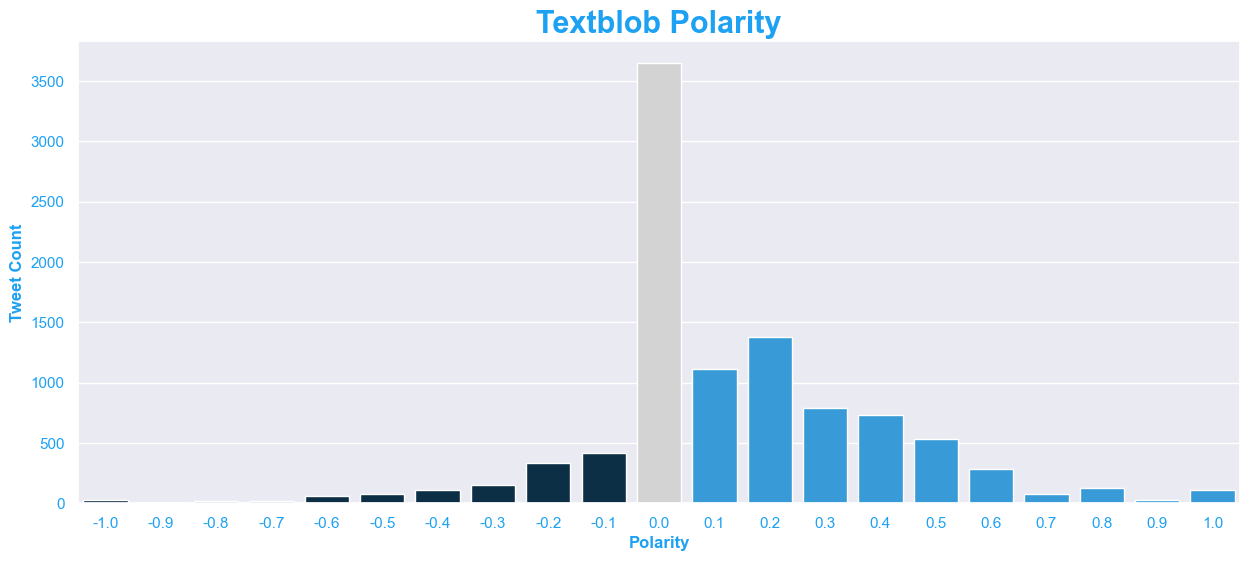

In [51]:
colors = ['#04314E' if polarity < 0 else 'lightgrey' if polarity == 0 else '#1DA1F2' for polarity in df_polarity_10K_count.index]

# Create Barchart and assign formatting
pyplot.figure(figsize=(15, 6))
seaborn.barplot(data= df_polarity_10K_count, y='textblob_count', x=df_polarity_10K_count.index, palette=colors)

seaborn.set(rc={'xtick.color':'#1DA1F2', 'ytick.color':'#1DA1F2'})
pyplot.title('Textblob Polarity', fontsize=22, weight='bold', color='#1DA1F2')
pyplot.xlabel('Polarity', color='#1DA1F2', weight='bold')
pyplot.ylabel('Tweet Count', color='#1DA1F2', weight='bold')

# Store visualization to file
pyplot.savefig("Textblob_polarity.png", format="png")

# Show plot
pyplot.show()

In [53]:
# Create Sentiment column
df_polarity_10K['sentiment'] = ['positive' if polarity > 0 
                                else 'negative' if polarity < 0 
                                else 'neutral' for polarity in df_polarity_10K['textblob_polarity']]

df_polarity_10K_sentiment = df_polarity_10K.groupby(pd.Grouper(key='sentiment')).size().reset_index(name='count').sort_values(by='count', ascending=False)
df_polarity_10K_sentiment.head(5)

,sentiment,count
0,positive,5504
1,neutral,3045
2,negative,1451


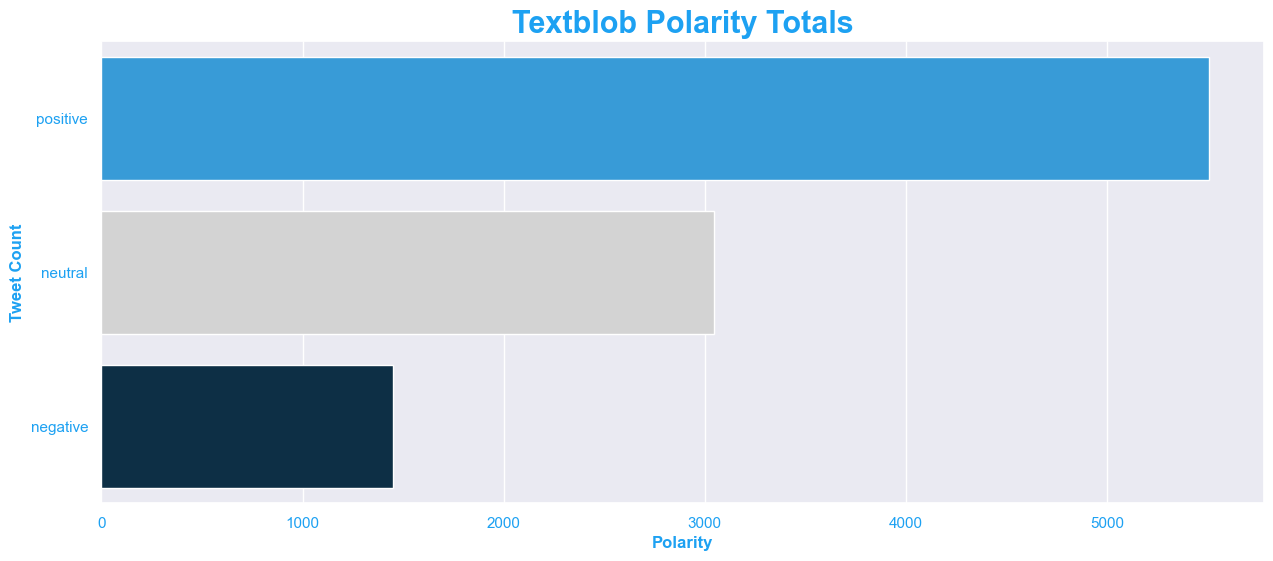

In [55]:
colors = ['#04314E' if sentiment == 'negative' else 'lightgrey' if sentiment == 'neutral' else '#1DA1F2' for sentiment in df_polarity_10K_sentiment['sentiment']]

# Create Barchart and assign formatting
pyplot.figure(figsize=(15, 6))
seaborn.barplot(data= df_polarity_10K_sentiment, x='count', y='sentiment', palette=colors)

seaborn.set(rc={'xtick.color':'#1DA1F2', 'ytick.color':'#1DA1F2'})
pyplot.title('Textblob Polarity Totals', fontsize=22, weight='bold', color='#1DA1F2')
pyplot.xlabel('Polarity', color='#1DA1F2', weight='bold')
pyplot.ylabel('Tweet Count', color='#1DA1F2', weight='bold')

# Store visualization to file
pyplot.savefig("Textblob_sentiment.png", format="png")

# Show plot
pyplot.show()

# **DASHBOARD**
**Use DASH TO build a dashboard using the plots created and display on a dash application**

In [156]:
# index.html
# style.css

----------------------------------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------------

# **ELON MUSK BLOCKED TWITTER API FOR SNSCRAPE 26/04/23..**
**TO BE CONTINUED..**

----------------------------------------------------------------------------------------------------------------------------------

# **SNSCRAPE**
**Scrape Tweets based on criteria and load into a pandas dataframe**

In [ ]:
scraper = snreddit.RedditSubredditScraper('ChatGPT')

data = []

for i, post in enumerate(scraper.get_posts()):
    data.append([post.date,
                 post.id,
                 post.body,
                 post.subreddit,
                 post.author
                 ]
                     )
    if i > 10:
        break

df = pd.DataFrame(data, columns=['date', 'id', 'content', 'subreddit', 'user'])

df


,date,id,content,subreddit,user
0,2023-04-28 07:15:21+00:00,t1_ji0y62a,😂,ChatGPT,phopkins_89
1,2023-04-28 07:15:17+00:00,t1_ji0y5wx,"Thanks, man, have fun with your new friend, and say hi to him from me also.",ChatGPT,AliUsmanAhmed
2,2023-04-28 07:15:06+00:00,t1_ji0y5fp,I can't not think of that one Undertale Meme video,ChatGPT,thisisthestoryallabo
3,2023-04-28 07:14:54+00:00,t1_ji0y4xe,"Meh, somebody will take over the world with a bomb or two or narutal warming will get us, in 50 years anyway. \nI'd rather the AI take us, at least can claim we made murder machines after trying to fix the climate.",ChatGPT,Magicmushies
4,2023-04-28 07:13:48+00:00,t1_ji0y20k,k.,ChatGPT,Lycyn
5,2023-04-28 07:13:45+00:00,t1_ji0y1wq,"Oh, cool, I didn't know that. In Germany it is not available.",ChatGPT,PresentFriend
6,2023-04-28 07:13:26+00:00,t1_ji0y144,It's posted as a response to the bot.,ChatGPT,mymoama
7,2023-04-28 07:13:25+00:00,t1_ji0y122,This is approach that will get us doomed by AI.,ChatGPT,dervu
8,2023-04-28 07:12:55+00:00,t1_ji0xzsy,What's the latest DAN prompt and where I can find it?,ChatGPT,catalina-ponor
9,2023-04-28 07:12:55+00:00,t1_ji0xzrp,Shocking.. in th funniest way!! 🤣🤣,ChatGPT,tammixr


In [ ]:
scraper = snreddit.RedditSearchScraper('r/ChatGPT')

data = []

for i, post in enumerate(scraper.get_items()):
    data.append([post.date,
                 post.id,
                 post.body,
                 post.author
                 ]
                     )
    if i > 10:
        break

df = pd.DataFrame(data, columns=['date', 'id', 'body', 'user'])

df


,date,id,body,user
0,2023-04-28 09:09:38+00:00,t1_ji15yq2,"**Attention! [Serious] Tag Notice**\n\n : Jokes, puns, and off-topic comments are not permitted in any comment, parent or child.\n\n : Help us by reporting comments that violate these rules.\n\n : Posts that are not appropriate for the [Serious] tag will be removed. \n\n Thanks for your cooperation and enjoy the discussion!\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/ChatGPT) if you have any questions or concerns.*",AutoModerator
1,2023-04-28 09:09:37+00:00,t1_ji15ypn,"Hey /u/daveisit, please respond to this comment with the prompt you used to generate the output in this post. Thanks!\n\n^(Ignore this comment if your post doesn't have a prompt.)\n\n***We have a [public discord server](https://discord.gg/rchatgpt). There's a free Chatgpt bot, Open Assistant bot (Open-source model), AI image generator bot, Perplexity AI bot, &amp;#x1F916; GPT-4 bot ([Now with Visual capabilities (cloud vision)!](https://cdn.discordapp.com/attachments/812770754025488386/1095397431404920902/image0.jpg)) and channel for latest prompts.[So why not join us?](https://discord.gg/NuefU36EC2)***\n\nPSA: For any Chatgpt-related issues email support@openai.com\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/ChatGPT) if you have any questions or concerns.*",AutoModerator
2,2023-04-28 09:04:34+00:00,t1_ji15mfb,"Hey /u/Initial_King6775, please respond to this comment with the prompt you used to generate the output in this post. Thanks!\n\n^(Ignore this comment if your post doesn't have a prompt.)\n\n***We have a [public discord server](https://discord.gg/rchatgpt). There's a free Chatgpt bot, Open Assistant bot (Open-source model), AI image generator bot, Perplexity AI bot, &amp;#x1F916; GPT-4 bot ([Now with Visual capabilities (cloud vision)!](https://cdn.discordapp.com/attachments/812770754025488386/1095397431404920902/image0.jpg)) and channel for latest prompts.[So why not join us?](https://discord.gg/NuefU36EC2)***\n\nPSA: For any Chatgpt-related issues email support@openai.com\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/ChatGPT) if you have any questions or concerns.*",AutoModerator
3,2023-04-28 09:00:51+00:00,t1_ji15dl4,"Hey /u/bingbing_, please respond to this comment with the prompt you used to generate the output in this post. Thanks!\n\n^(Ignore this comment if your post doesn't have a prompt.)\n\n***We have a [public discord server](https://discord.gg/rchatgpt). There's a free Chatgpt bot, Open Assistant bot (Open-source model), AI image generator bot, Perplexity AI bot, &amp;#x1F916; GPT-4 bot ([Now with Visual capabilities (cloud vision)!](https://cdn.discordapp.com/attachments/812770754025488386/1095397431404920902/image0.jpg)) and channel for latest prompts.[So why not join us?](https://discord.gg/NuefU36EC2)***\n\nPSA: For any Chatgpt-related issues email support@openai.com\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/ChatGPT) if you have any questions or concerns.*",AutoModerator
4,2023-04-28 08:59:21+00:00,t1_ji15a28,"Hey /u/______b______, please respond to this comment with the prompt you used to generate the output in this post. Thanks!\n\n^(Ignore this comment if your post doesn't have a prompt.)\n\n***We have a [public discord server](https://discord.gg/rchatgpt). There's a free Chatgpt bot, Open Assistant bot (Open-source model), AI image generator bot, Perplexity AI bot, &amp;#x1F916; GPT-4 bot ([Now with Visual capabilities (cloud vision)!](https://cdn.discordapp.com/attachments/812770754025488386/1095397431404920902/image0.jpg)) and channel for latest prompts.[So why not join us?](https://discord.gg/NuefU36EC2)***\n

In [ ]:
scraper = sntwitter.TwitterSearchScraper('lang:en until:2023-04-17 since:2023-03-30 #ChatGPT')

data = []

for i, tweets in enumerate(scraper.get_items()):
    data.append([tweets.date,
                 tweets.id,
                 tweets.content,
                 tweets.user.username,
                 tweets.likeCount,
                 tweets.retweetCount
                 ]
                     )
    if i > 10:
        break

df = pd.DataFrame(data, columns=['date', 'id', 'content', 'username', 'like_count', 'retweet_count'])

df.head(5)

'''

ERROR #403
TWITTER HAS BLOCKED ALL SCRAPERS AS OF 26TH MARCH 2023 - NO KNOWN SOLUTION YET
LETS CONTINUE WITH 500K TWEETS FROM KAGGLE

'''